In [308]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="darkgrid")

# Reading traind and test files

In [309]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
print(f"Train shape = {train.shape}\nTest shape = {test.shape}")

Train shape = (7613, 5)
Test shape = (3263, 4)


In [310]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [311]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# EDA

In [312]:
#checking null values
print(f"NULL values\n\nTrain\n{train.isnull().sum()}\n\nTest\n{test.isnull().sum()}")

NULL values

Train
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Test
id             0
keyword       26
location    1105
text           0
dtype: int64


In [313]:
#train describe
train.describe(include="all")

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [314]:
#test describe
test.describe(include="all")

,id,keyword,location,text
count,3263.000000,3237,2158,3263
unique,NaN,221,1602,3243
top,NaN,deluged,New York,11-Year-Old Boy Charged With Manslaughter of T...
freq,NaN,23,38,3
mean,5427.152927,NaN,NaN,NaN
std,3146.427221,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN
25%,2683.000000,NaN,NaN,NaN
50%,5500.000000,NaN,NaN,NaN
75%,8176.000000,NaN,NaN,NaN


In [315]:
#disaster or not frequency
target_counts=train["target"].value_counts()
print(target_counts)

p1= round(100*(target_counts[1]/sum(target_counts)),2)
p2= round(100-p1,2)
print(f"\nPercentage of Disaster Tweets: {p1}%\nPercentage of Non Disaster Tweets: {p2}%")

0    4342
1    3271
Name: target, dtype: int64

Percentage of Disaster Tweets: 42.97%
Percentage of Non Disaster Tweets: 57.03%


Text(0.5, 1.0, 'Disaster (1) or not (0) barplot')

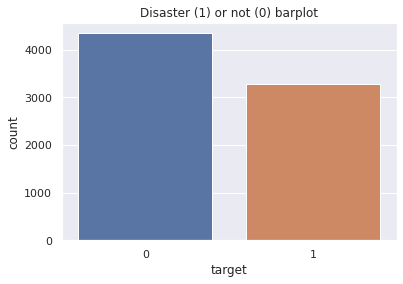

In [316]:
sns.countplot(train["target"])
plt.title("Disaster (1) or not (0) barplot")

In [317]:
#maximum length tweet
print("Train max length tweet:",train["text"].apply(len).max())
print("Test max length tweet:",test["text"].apply(len).max(),"\n")

#minimum length tweet
print("Train min length tweet:",train["text"].apply(len).min())
print("Test min length tweet:",test["text"].apply(len).min())


Train max length tweet: 157
Test max length tweet: 151 

Train min length tweet: 7
Test min length tweet: 5


In [318]:
#separating train into 2 datasets to get value_counts of keywords
print("Disaster Keywords\n\n",train[train["target"]==1]["keyword"].value_counts()[:10],"\n")
print("Non Disaster Keywords\n\n",train[train["target"]==0]["keyword"].value_counts()[:10])

Disaster Keywords

 derailment           39
wreckage             39
outbreak             39
oil%20spill          37
debris               37
typhoon              37
rescuers             32
suicide%20bombing    32
evacuated            32
suicide%20bomb       32
Name: keyword, dtype: int64 

Non Disaster Keywords

 body%20bags    40
harm           37
armageddon     37
ruin           36
wrecked        36
deluge         36
explode        35
siren          35
fear           35
twister        35
Name: keyword, dtype: int64


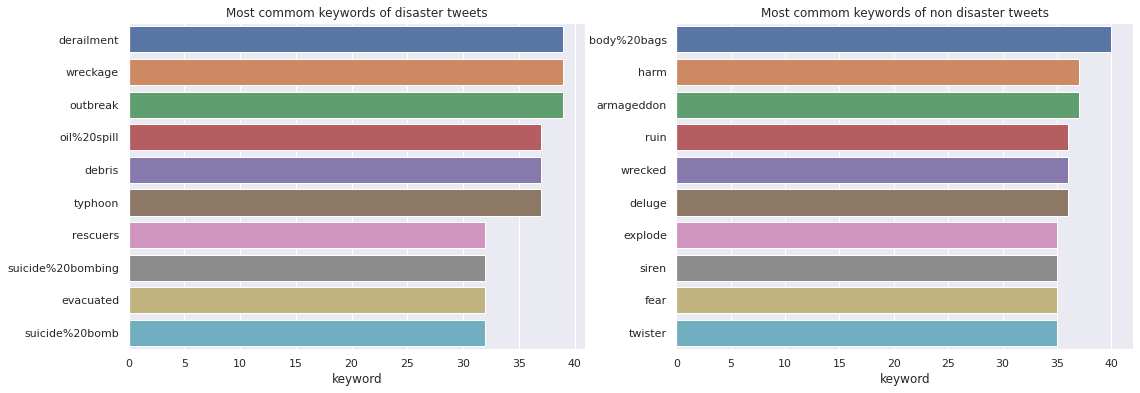

In [319]:
#barplots of keywords
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.title("Most commom keywords of disaster tweets")
sns.barplot(x=train[train["target"]==1]["keyword"].value_counts()[:10],\
              y=train[train["target"]==1]["keyword"].value_counts()[:10].index,orient="h")

plt.subplot(122)
plt.title("Most commom keywords of non disaster tweets")
sns.barplot(x=train[train["target"]==0]["keyword"].value_counts()[:10],\
              y=train[train["target"]==0]["keyword"].value_counts()[:10].index,orient="h")
plt.show()

In [320]:
#separating train into 2 datasets to get value_counts of locations
print("Disaster Keywords\n\n",train[train["target"]==1]["location"].value_counts()[:10],"\n")
print("Non Disaster Keywords\n\n",train[train["target"]==0]["location"].value_counts()[:10])

Disaster Keywords

 USA               67
United States     27
Nigeria           22
India             20
Mumbai            19
New York          16
UK                16
London            16
Washington, DC    15
Canada            13
Name: location, dtype: int64 

Non Disaster Keywords

 New York           55
USA                37
London             29
United States      23
Los Angeles, CA    18
Canada             16
Kenya              15
Everywhere         12
UK                 11
Florida            11
Name: location, dtype: int64


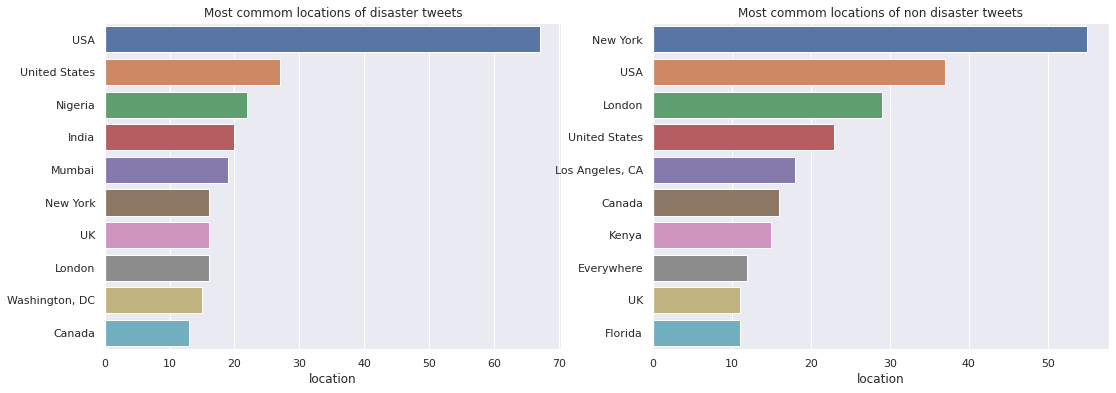

In [321]:
#barplots of locations
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.title("Most commom locations of disaster tweets")
sns.barplot(x=train[train["target"]==1]["location"].value_counts()[:10],\
              y=train[train["target"]==1]["location"].value_counts()[:10].index,orient="h")

plt.subplot(122)
plt.title("Most commom locations of non disaster tweets")
sns.barplot(x=train[train["target"]==0]["location"].value_counts()[:10],\
              y=train[train["target"]==0]["location"].value_counts()[:10].index,orient="h")
plt.show()

In [322]:
#checking for line break in tweets
train['text'].str.contains("\n").value_counts()

False    7178
True      435
Name: text, dtype: int64

# Feature Engineering

In [323]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import string
stemmer_snowball = SnowballStemmer("english")

In [324]:
def clear_data(tweet):
    #removes punctuation, stopwords
    removed = []
    for token in tweet:
        if (token not in stopwords.words('english')) and token not in string.punctuation\
        and token!="\n":
            removed.append(token)
    return removed

In [325]:
def combine_text(tweet):
    combined = ' '.join(tweet)
    return combined



In [326]:
def apply_lemma(tweet):
    return [stemmer_snowball.stem(token) for token in tweet]

In [327]:
#transforming all tweets into lower case letters
train["text"] = train["text"].apply(lambda x: x.lower())
test["text"] = test["text"].apply(lambda x: x.lower())

In [328]:
#Tokenization
train["text"] = train["text"].apply(word_tokenize)
test["text"] = test["text"].apply(word_tokenize)


In [329]:
train["text"][:10]

0    [our, deeds, are, the, reason, of, this, #, ea...
1     [forest, fire, near, la, ronge, sask, ., canada]
2    [all, residents, asked, to, 'shelter, in, plac...
3    [13,000, people, receive, #, wildfires, evacua...
4    [just, got, sent, this, photo, from, ruby, #, ...
5    [#, rockyfire, update, =, >, california, hwy, ...
6    [#, flood, #, disaster, heavy, rain, causes, f...
7    [i, 'm, on, top, of, the, hill, and, i, can, s...
8    [there, 's, an, emergency, evacuation, happeni...
9    [i, 'm, afraid, that, the, tornado, is, coming...
Name: text, dtype: object

In [330]:
train["text"] = train["text"].apply(clear_data)
test["text"] = test["text"].apply(clear_data)

In [331]:
train["text"][:10]

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, 'shelter, place, notified, ...
3    [13,000, people, receive, wildfires, evacuatio...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
5    [rockyfire, update, california, hwy, 20, close...
6    [flood, disaster, heavy, rain, causes, flash, ...
7               ['m, top, hill, see, fire, woods, ...]
8    ['s, emergency, evacuation, happening, buildin...
9             ['m, afraid, tornado, coming, area, ...]
Name: text, dtype: object

In [333]:
#recombine text
train["text"] = train["text"].apply(apply_lemma)
test["text"] = test["text"].apply(apply_lemma)

In [335]:
train["text"][:10]

0    [deed, reason, earthquak, may, allah, forgiv, us]
1         [forest, fire, near, la, rong, sask, canada]
2    [resid, ask, shelter, place, notifi, offic, ev...
3    [13,000, peopl, receiv, wildfir, evacu, order,...
4    [got, sent, photo, rubi, alaska, smoke, wildfi...
5    [rockyfir, updat, california, hwi, 20, close, ...
6    [flood, disast, heavi, rain, caus, flash, floo...
7                ['m, top, hill, see, fire, wood, ...]
8    ['s, emerg, evacu, happen, build, across, street]
9               ['m, afraid, tornado, come, area, ...]
Name: text, dtype: object

In [337]:
train["text"] = train["text"].apply(combine_text)
test["text"] = test["text"].apply(combine_text)

In [338]:
train["text"][:10]

0            deed reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3    13,000 peopl receiv wildfir evacu order califo...
4    got sent photo rubi alaska smoke wildfir pour ...
5    rockyfir updat california hwi 20 close direct ...
6    flood disast heavi rain caus flash flood stree...
7                        'm top hill see fire wood ...
8            's emerg evacu happen build across street
9                      'm afraid tornado come area ...
Name: text, dtype: object

# Validation

In [339]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

vec_rf = Pipeline([("Tfid",TfidfVectorizer()),("rfclass",RandomForestClassifier())])
vec_xg = Pipeline([("Tfid",TfidfVectorizer()),("xgboost",XGBClassifier())])
vec_nb = Pipeline([("Tfidf",TfidfVectorizer()),("clf",MultinomialNB())])

In [340]:
X = train["text"]
y = train["target"]
results_nb = []
results_xg = []
results_rf = []

kf = RepeatedKFold(n_splits=2,n_repeats=5,random_state=10)

for train_l, valid_l in kf.split(X):
    X_train, X_valid = X.iloc[train_l],X.iloc[valid_l]
    y_train, y_valid = y.iloc[train_l],y.iloc[valid_l]
    
    vec_nb.fit(X_train,y_train)
    p = vec_nb.predict(X_valid)
    results_nb.append(f1_score(p,y_valid))
    
    vec_xg.fit(X_train,y_train)
    p = vec_xg.predict(X_valid)
    results_xg.append(f1_score(p,y_valid))
    
    vec_rf.fit(X_train,y_train)
    p = vec_rf.predict(X_valid)
    results_rf.append(f1_score(p,y_valid))

In [341]:
print("Random Forest = ",np.mean(results_rf))
print("XGB = ",np.mean(results_xg))
print("Naive Baiyes = ",np.mean(results_nb))

Random Forest =  0.6971006871249636
XGB =  0.6144053374886235
Naive Baiyes =  0.7277417464108769


# Create Submission

In [342]:
vec_nb = Pipeline([("Tfidf",TfidfVectorizer()),("clf",MultinomialNB())])
vec_nb.fit(train["text"],train["target"])
p = vec_nb.predict(test["text"])

In [343]:
sub = pd.Series(p,index=test["id"],name="target")
sub.to_csv("submission.csv",header=True)